In [1]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import timm
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# 2. Dataset paths
train_path = "/kaggle/input/bone-fracture-dataset/Bone_Fracture_Binary_Classification/train/"
val_path =  "/kaggle/input/bone-fracture-dataset/Bone_Fracture_Binary_Classification/val/"
test_path = "/kaggle/input/bone-fracture-dataset/Bone_Fracture_Binary_Classification/test/"

In [3]:
# 3. Get image paths
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

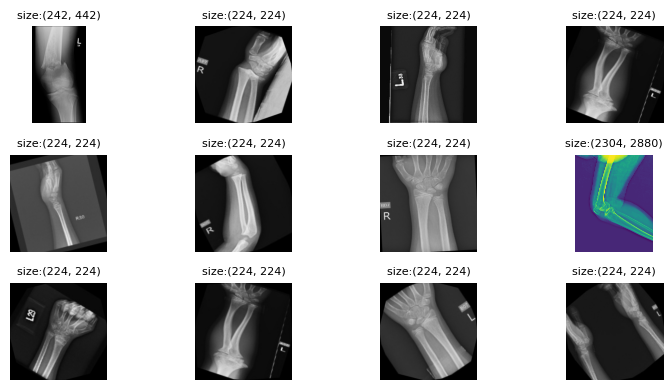

In [4]:
# 4. Display dataset
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))
    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)
    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [5]:
# 5. Handle transparency
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode in ['RGBA', 'LA']:
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA').convert('L')
        else:
            img = img.convert('L')
        return img

In [6]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

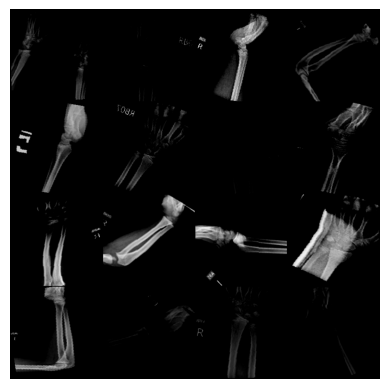

In [8]:
# 8. Show batch

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [9]:
# 9. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
# 10. Load EfficientNet-b0
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2)

# Freeze all
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, 2)
)

model = model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [11]:
# 11. Optimizer & Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

In [12]:
# 12. Training

def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy, all_labels, all_predictions

def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_losses, val_losses, accuracies = [], [], []
    all_labels, all_predictions = [], []
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, acc, labels, preds = validate(model, val_loader, criterion)
        scheduler.step()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(acc)
        all_labels.extend(labels)
        all_predictions.extend(preds)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Acc: {acc:.2f}%")
    return train_losses, val_losses, accuracies, all_labels, all_predictions

In [13]:
train_losses, val_losses, accuracies, all_labels, all_predictions = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

 31%|███       | 4/13 [00:03<00:08,  1.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 1/20 - Train Loss: 0.6571, Val Loss: 0.6217, Acc: 70.08%


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch 2/20 - Train Loss: 0.5760, Val Loss: 0.5756, Acc: 74.91%


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 3/20 - Train Loss: 0.5319, Val Loss: 0.5590, Acc: 74.19%


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch 4/20 - Train Loss: 0.5042, Val Loss: 0.5304, Acc: 76.48%


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 5/20 - Train Loss: 0.4835, Val Loss: 0.5274, Acc: 75.03%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 6/20 - Train Loss: 0.4733, Val Loss: 0.5184, Acc: 76.00%


100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch 7/20 - Train Loss: 0.4685, Val Loss: 0.5145, Acc: 76.72%


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 8/20 - Train Loss: 0.4603, Val Loss: 0.5150, Acc: 75.75%


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch 9/20 - Train Loss: 0.4534, Val Loss: 0.5140, Acc: 75.75%


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 10/20 - Train Loss: 0.4483, Val Loss: 0.4992, Acc: 77.56%


100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


Epoch 11/20 - Train Loss: 0.4421, Val Loss: 0.5096, Acc: 75.87%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 12/20 - Train Loss: 0.4435, Val Loss: 0.5019, Acc: 76.84%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch 13/20 - Train Loss: 0.4417, Val Loss: 0.5060, Acc: 76.24%


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 14/20 - Train Loss: 0.4375, Val Loss: 0.5007, Acc: 76.24%


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch 15/20 - Train Loss: 0.4428, Val Loss: 0.4929, Acc: 78.05%


100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


Epoch 16/20 - Train Loss: 0.4335, Val Loss: 0.5013, Acc: 76.48%


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 17/20 - Train Loss: 0.4283, Val Loss: 0.5040, Acc: 76.72%


100%|██████████| 13/13 [00:07<00:00,  1.71it/s]


Epoch 18/20 - Train Loss: 0.4327, Val Loss: 0.4982, Acc: 76.36%


100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch 19/20 - Train Loss: 0.4340, Val Loss: 0.4948, Acc: 76.48%


100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

Epoch 20/20 - Train Loss: 0.4285, Val Loss: 0.4964, Acc: 77.44%


In [14]:
# 13. Save model
os.makedirs('FracturedDataEfficientNet', exist_ok=True)
torch.save(model.state_dict(), 'FracturedDataEfficientNet/model.pt')

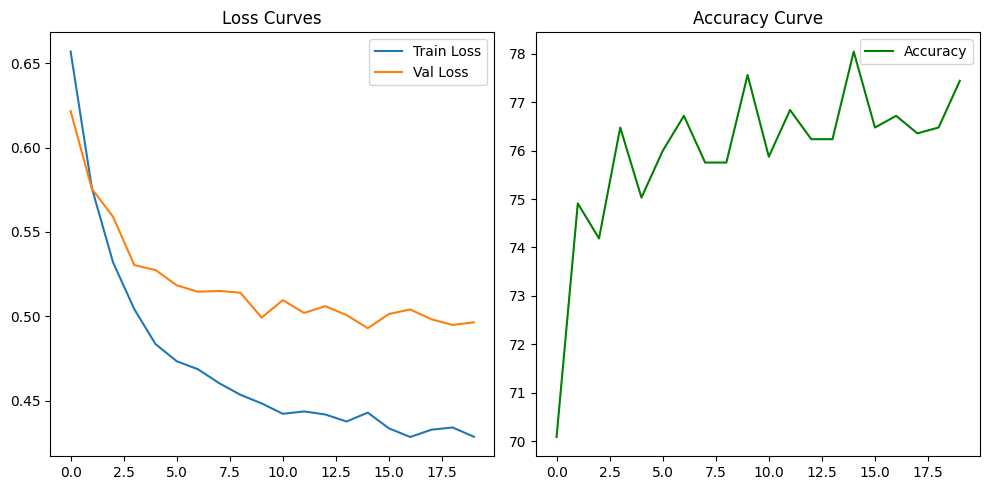

In [15]:
# 14. Plot results
def plot_curves(train_losses, val_losses, accuracies):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accuracies)

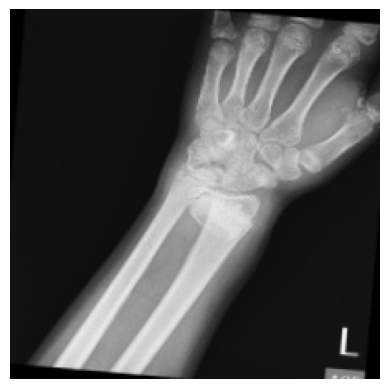

Predict: 0 (fractured)
True label: fractured


In [16]:
# 15. Predict single image
def predict_image(image_path, model, transforms, device):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

image_path = random.choice(get_image_paths(test_path))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()
predicted_class = predict_image(image_path, model, val_transforms, device)
true_class = image_path.split('/')[-2]
print(f"Predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"True label: {true_class}")

In [17]:
# 16. Test accuracy
test_transforms = val_transforms
test_ds = ImageFolder(test_path, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)

def measure_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

print(f"Validation Accuracy: {measure_accuracy(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {measure_accuracy(model, test_dataloader):.2f}%")

Validation Accuracy: 77.44%
Test Accuracy: 73.91%


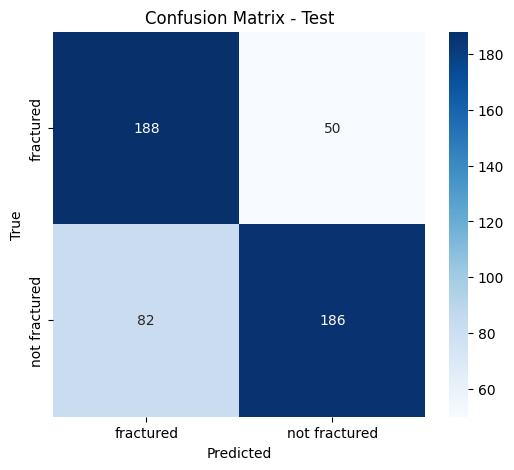

In [18]:
# 17. Classification report
def get_predictions(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = get_predictions(model, test_dataloader)
class_names = test_ds.classes

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test")
plt.show()

In [19]:
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

print("=== Overall Metrics (Macro Average) ===")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")

=== Classification Report ===
               precision    recall  f1-score   support

    fractured       0.70      0.79      0.74       238
not fractured       0.79      0.69      0.74       268

     accuracy                           0.74       506
    macro avg       0.74      0.74      0.74       506
 weighted avg       0.74      0.74      0.74       506

=== Overall Metrics (Macro Average) ===
Accuracy : 0.7391
Precision: 0.7422
Recall   : 0.7420
F1 Score : 0.7391
